<a href="https://colab.research.google.com/github/dcolinmorgan/test/blob/master/LTRC_TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTRC dataset analyzed for time series prediction

ran panda nets for control and case [HERE in "run large PANDA"](https://colab.research.google.com/drive/1ER3FudwHf62xpVaqtA55XevX--E4INUe?authuser=1#scrollTo=3NiZai_nLIts&uniqifier=2)

In [ ]:
import os,glob,gc
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import math,keras,time
import tensorflow as tf

timestr = time.strftime("%Y%m%d-%H%M")

In [ ]:
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

from keras.preprocessing import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.models import load_model

from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout,Activation#,CuDNNLSTM
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


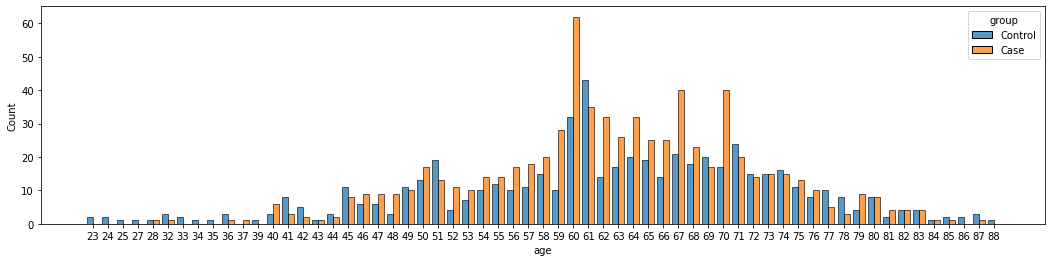

In [ ]:
Image(filename='drive/My Drive/LARGE_PANDA/LTRC_age_hist.png')
# Image(url='')

# FORMAT DATA

In [ ]:
def plot_series(time, series, jj,format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(jj)
    plt.grid(True)
    plt.savefig(('drive/My Drive/'+jj+'.png'))

# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   series = tf.expand_dims(series, axis=-1)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
#   dataset = dataset.batch(batch_size).prefetch(1)
#   return dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## load case OR control

In [ ]:
links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',names=['TF','genes'])

In [ ]:
# tdata=pd.DataFrame(np.transpose(CASE))#.interpolate(method='time')
# tdata['Datetime'] = pd.to_datetime('19'+(CASE_ages[0:]['ages'].astype(str)) + ' ' +'10:00:00 ')
# tdata = tdata.set_index('Datetime')
# # ALL.iloc[1,:].to_list()#.dropna(how='any')
# tdata=tdata.interpolate(method='time')

# tdata=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case.txt',usecols=np.arange(100),index_col=0)

In [ ]:
# np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control',tdata)
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.npy'))
tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))
tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcase_ages.txt',header=None)[0]
# tdata_ages[0]
tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
tdata=tdata.T

In [ ]:
# tdata=pd.DataFrame(CASE.T, index=CASE.columns)#.interpolate(method='time')
# tdata['Datetime'] = pd.to_datetime('19'+(CASE.columns.astype(str)) + ' ' +'10:00:00 ')
# tdata = tdata.set_index('Datetime')
# # ALL.iloc[1,:].to_list()#.dropna(how='any')
# tdata=tdata.interpolate(method='time')

# tdata=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.txt',usecols=np.arange(101),index_col=0)

In [ ]:
# # np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control',tdata)
# # tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.npy'))
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))
# tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcontrol_ages.txt',header=None)[0]
# # tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# tdata=tdata.T

In [ ]:
t2data=tdata.iloc[:,0:10000]
print(t2data.shape)
del tdata
tdata=pd.DataFrame()

(55, 10000)


#preprocess timeseries A
*  https://github.com/Tony607/Keras_TimeseriesGenerator/blob/master/TimeseriesGenerator.ipynb

*  https://www.kaggle.com/nicapotato/multivar-lstm-ts-regression-keras?select=test.csv

In [ ]:
# split_time = 48
# heat=pd.DataFrame()
# window_size = 6
# batch_size = 12
# shuffle_buffer_size = 12

# i=int(np.random.randint(1, high=tdata.shape[0], size=1) )
# series=np.array(tdata.iloc[i,:])

# time_train = tdata.columns[:split_time]
# x_train = series[:split_time]
# time_valid = tdata.columns[split_time:]
# x_valid = series[split_time:]
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [ ]:

# # n_input=6
# # tdata=tdata[0:54] ## make it divisible by 6 year chunks for lookback
# # tdata=tdata[::-1]
# # add_dates = [pd.Timestamp(tdata.index[-1]) + DateOffset(years=x) for x in range(0,n_input+1) ]
# # future_dates = pd.DataFrame(0,index=add_dates[1:],columns=tdata.columns)

# # t2data=tdata.append(future_dates)

# t2data=np.array(tdata)

# scaler_multi = MinMaxScaler(feature_range=(0, 1)) ## batch normalization between layers
# scaler_multi.fit_transform(t2data.reshape(-1, 1))
# t2data = scaler_multi.transform(t2data)


In [ ]:
# look_back = 6
# train_data_gen = TimeseriesGenerator(train_x, train_x,
#                                length=look_back, sampling_rate=1,stride=1,
#                                batch_size=6)
# test_data_gen = TimeseriesGenerator(test_x, test_x,
#                                length=look_back, sampling_rate=1,stride=1,
#                                batch_size=1)

# pred_data_gen = TimeseriesGenerator(t2data[::-1], t2data[::-1],
#                                length=look_back, sampling_rate=1,stride=1,
#                                batch_size=1)


train = t2data#[::-1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
n_input = 5
lookback=n_input
n_features = t2data.data.shape[1]
generator = TimeseriesGenerator(train,train,sampling_rate=1, length=lookback)#, batch_size=6)

# train=pd.DataFrame(t2data)
# # train_x=train.drop([:-12])
# # train_y=train[-12:-6]
# train_x=train.drop(train.index[54:60])
# train_y=train.drop(train.index[48:59])
  ### subset

trainA=train#.to_numpy()#train[:-6] 
trainA=trainA[:,np.var(trainA,axis=0)<.075] ## limit genes to those that change for prediction
# trainA=trainA[:,np.var(trainA,axis=0)<.0001]
train_x=trainA[:-6]
train_y=trainA[-6:]

training_sequence = TimeseriesGenerator(train_x, train_x, length=lookback,batch_size=1)
validation_sequence = TimeseriesGenerator(train_y, train_y,  length=lookback,batch_size=1)

# look_back = 1 
# train_x, train_y = create_data_set(train, look_back) 
# # test_x, test_y = create_data_set(test, look_back) 
# train_x = np.reshape(train_x,
#                         (train_x.shape[0], 1, train_x.shape[1])) 
# # test_x = np.reshape(test_x, 
# #                        (test_x.shape[0], 1, test_x.shape[1]))


In [ ]:
[train_x.data.shape,train_y.data.shape]

[(51, 93), (6, 93)]

# preprocess time series B

In [ ]:
# from zipfile import ZipFile
# import os

# uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
# zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
# zip_file = ZipFile(zip_path)
# zip_file.extractall()
# csv_path = "jena_climate_2009_2016.csv"

# df = pd.read_csv(csv_path)
# split_fraction = 0.715
# train_split = int(split_fraction * int(df.shape[0]))
# step = 6

# past = 720
# future = 72
# learning_rate = 0.001
# batch_size = 256
# epochs = 10

df=tdata
# train_split = 48 #int(split_fraction * int(df.shape[0]))
step = 1
past = 6*(int(df.shape[0]/6)-2) #42 #720
future = 6 #72
train_split = past
learning_rate = 1#0.001
batch_size = 256
epochs = 10

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [ ]:
# print(
#     "The selected parameters are:",
#     ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
# )
# selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
# features = df[selected_features]
# features.index = df[date_time_key]
# features.head()

# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()

# train_data = features.loc[0 : train_split - 1]
# val_data = features.loc[train_split:]

sub=links[0:tdata.shape[1]]#.str

df.columns=sub.TF+'_'+sub.genes
selected_features = df.columns
features = df[selected_features]
features.index = df.index#[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
[train_data.shape,val_data.shape]

[(42, 99), (15, 99)]

In [ ]:
start = past + future
end = start + train_split
x_train = train_data[[i for i in range(train_data.shape[1])]].values
y_train = features.iloc[future:start]#[[1]]
sequence_length = int(past / step)
end=start
start=future


[x_train.shape,y_train.shape]
# past=0
# future=6
# start = past + future # 6 + 0
# end = start + train_split

# x_train = tdata[:train_split]#[[i for i in range(XX)]].values
# # y_train = tdata[-XX:]#features.iloc[start:end][[1]]
# y_train = features.iloc[start:end]#[[1]]

# sequence_length = int(past / step)

[(42, 99), (42, 99)]

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
# x_end = len(val_data) - past - future

# label_start = train_split + past + future

x_val = features.iloc[0:6]#[[i for i in range(99)]].values
y_val = features.iloc[42:48]#[[1]]

# x_val = tdata[train_split:train_split+future]#[[i for i in range(XX)]].values
# # y_train = tdata[-XX:]#features.iloc[start:end][[1]]
# y_val = features.iloc[past:future]#[[1]]
print([x_val.shape,y_val.shape])
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

[(6, 99), (6, 99)]


In [ ]:

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (1, 42, 99)
Target shape: (1, 99)


In [ ]:
training_sequence=dataset_train
lookback=tdata.shape[0]

#preprocess time series C

In [ ]:
dataset_x=t2data[:42]
dataset_y=t2data[42:]
# normalize the dataset
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(dataset_x)#.reshape(-1, 1))
dataset_x = scaler_multi.transform(dataset_x)
dataset_y = scaler_multi.transform(dataset_y)
# split into train and test sets
# dataset_x
train_size = int(len(dataset_x) * 0.67)
test_size = len(dataset_x) - train_size
train_x, test_x = dataset_x[0:train_size,:], dataset_x[train_size:len(dataset_x),:]

# train_x=train_x.reshape(1,train_x.shape[0],train_x.shape[1])

train_y, test_y = dataset_y[0:train_size,:], dataset_y[train_size:len(dataset_y),:]

In [ ]:
lookback = 6


training_sequence = TimeseriesGenerator(train_x, train_x, length=lookback,batch_size=1)
validation_sequence = TimeseriesGenerator(train_y, train_y,  length=lookback,batch_size=1)

#RUN A,B or C

In [ ]:
model = Sequential()
## graph neural network then (lower D space) to LSTM (neighborhood) NOT conv1d (spatial from images)
initializer=tf.keras.initializers.Orthogonal()
model.add(LSTM(1024, input_shape=(look_back, training_sequence.data.shape[2]),return_sequences=True, kernel_initializer=initializer)) #orthoganal initialization for weight, he  # 5 time steps and 32831 features/genes
# model.add(Activation('relu'))
# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
# model.add(Activation('relu'))
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(64,activation='relu'))),
# model.add(Dropout(0.15))
# model.add((LSTM(32,activation='relu'))),
model.add(Dense(training_sequence.data.shape[2]))
model.compile(loss='mse', optimizer='adam',metrics=['mse','accuracy'])
print(model.summary())

# generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=1)
# # define model
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))   # 2 x 3
# model.add(Dense(3))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
# # make a one step prediction out of sample
# x_input = array([[90, 95], [100, 105],[12,21]]).reshape((1, n_input, n_features))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 5, 1024)           4608000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 5, 512)            3147776   
_________________________________________________________________
lstm_12 (LSTM)               (None, 5, 256)            787456    
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 128)            197120    
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
Total params: 8,796,260
Trainable params: 8,796,260
Non-trainable params: 0
____________________________________________

In [ ]:

# generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=1)
# # define model
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))   # 2 x 3
# model.add(Dense(3))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
# # make a one step prediction out of sample
# x_input = array([[90, 95], [100, 105],[12,21]]).reshape((1, n_input, n_features))

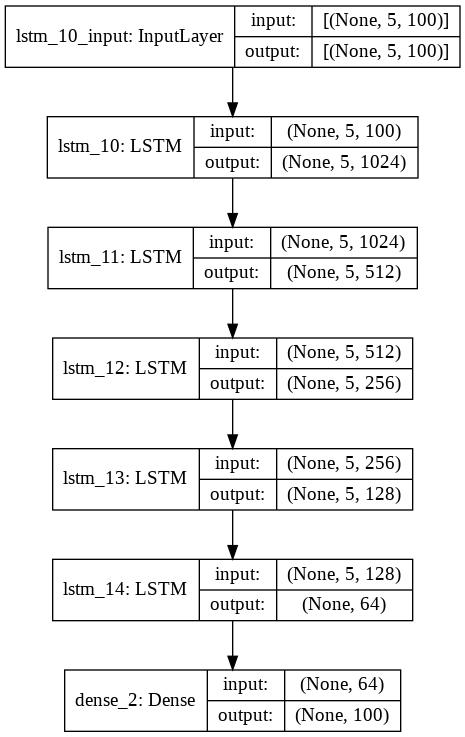

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
history =model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M")
model.save('drive/MyDrive/LARGE_PANDA/model_output/CASE_'+timestr+'.h')
# model.save('drive/MyDrive/LARGE_PANDA/model_output/CONTROL.h')

INFO:tensorflow:Assets written to: drive/MyDrive/LARGE_PANDA/model_output/CASE_20210218-1749.h/assets


INFO:tensorflow:Assets written to: drive/MyDrive/LARGE_PANDA/model_output/CASE_20210218-1749.h/assets


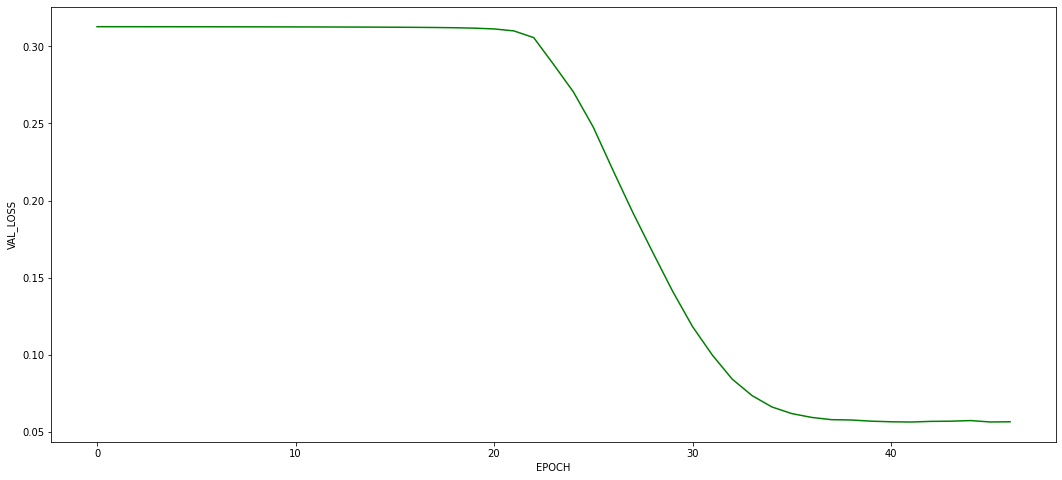

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['val_loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("VAL_LOSS")
plt.show()


## load and predict

In [ ]:
from keras.models import load_model
model = load_model('drive/MyDrive/LARGE_PANDA/model_output/CASE'+timestr+'.h')

In [ ]:
testX[-look_back+1:,1,]#.shape

array([[0.95273559, 0.76566714, 0.17298727, ..., 0.0614395 , 0.16529403,
        0.14272238],
       [0.48274386, 0.70188368, 0.49077   , ..., 0.52195017, 0.59214787,
        0.49445833],
       [0.48274386, 0.70188368, 0.49077   , ..., 0.52195017, 0.59214787,
        0.49445833],
       [0.17029206, 0.63238668, 0.67908795, ..., 0.79417896, 0.81301061,
        0.63556043]])

In [ ]:
# t2data=t2data[::-1]
# train = training_sequence.data[48:]
# scaler = MinMaxScaler()
# scaler.fit(train)
# train = scaler.transform(train)
# batch=[]
pred_list = []
# batch = train_y[-n_input:].reshape((1, n_input, t2data.shape[1]))
# n_input=5
##subset
# train = train
# scaler = MinMaxScaler()
# scaler.fit(train)
# train = scaler.transform(train)
# batch = train_y[-n_input:].reshape((1, n_input, train.shape[1]))
##worked nicely
# batch = train_y[-n_input:].reshape((1, n_input, t2data.shape[1]))

batch = testX[-look_back:,:,:]#testX[-look_back:].reshape((look_back, look_back, t2data.shape[1]))


# batch=batch.T
for i in range(look_back+1):
  # print(batch[0,1:,:])
  pred_list.append(model.predict(batch))#[0])  ## comment T then uncomment
  batch = np.append(batch[0,1:,:],pred_list[i],axis=0)
  # print([batch.shape,pred_list[i].T.shape])
  # batch=batch.T
  # print(pred_list[i])
  batch = np.expand_dims(batch, 0)
  # print([i,batch.shape])
print(pd.DataFrame(np.squeeze(pred_list)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


                                                   0
0  [[0.48314038, 0.6839095, 0.447099, 0.32684484,...
1  [[1.2755535, 2.1479166, 0.6608889, 5.031566, 8...
2  [[1.2724749, 2.1687782, 0.57289326, 5.120007, ...
3  [[1.3666003, 2.4289517, 0.6140203, 5.2877493, ...
4  [[1.5218877, 2.5331743, 0.6704508, 5.4272738, ...
5  [[1.5499594, 2.5619068, 0.6893188, 5.3994894, ...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
pred_list=pd.DataFrame(np.concatenate((pred_list[1:])))

In [ ]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# t2data = scaler.fit_transform(t2data)
pred_list = scaler.fit_transform(pred_list)

# train = scaler.inverse_transform(train)
# pred=pd.DataFrame(train)[::-1]
# pred=pd.DataFrame(trainA)
pred=pd.DataFrame(train).append(pd.DataFrame(pred_list))
pred=pred.reset_index()
del pred['index']

# trainY = scaler.inverse_transform([trainX])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testX])

In [ ]:
# # pred_list=pd.DataFrame(np.reshape(pred_list,[lookback,t2data.shape[1]]))
# pred_list=pd.DataFrame(np.reshape(pred_list,[lookback,trainA.shape[1]]))
# # pred_list=scaler.inverse_transform((pred_list))
# # scaler = MinMaxScaler()
# # scaler.fit(trainA)
# # pred_list=scaler.transform((pred_list))
# # pred_list = []
# # batch = train[-n_input:].reshape((1, n_input, t2data.shape[1]))
# # pred_list.append(model.predict(batch.T))
# pred_list=(np.squeeze(pred_list))
# pred_list=pd.DataFrame(pred_list)
# print(pred_list)

# pred=pd.DataFrame(t2data[::-1])[6:54]
# # pred=pd.DataFrame(trainA)
# pred=pred.append(pred_list)
# pred=pred.reset_index()
# del pred['index']

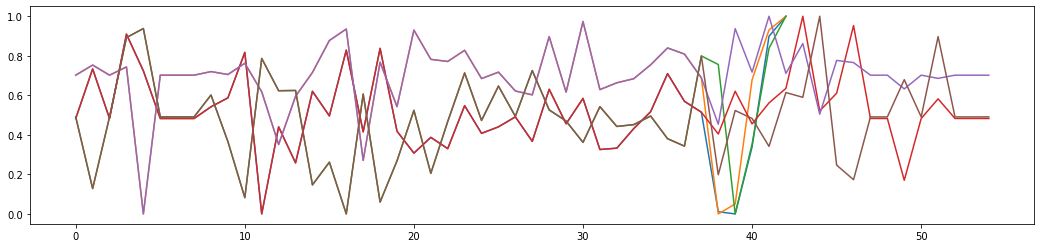

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(pred.iloc[:,0:3])
w=plt.plot(t2data[:,0:3])

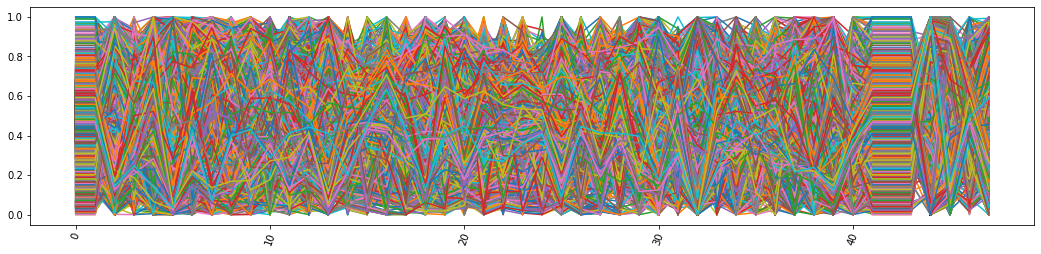

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(t2data[::-1][6:54])
z=plt.xticks(rotation=70)

In [ ]:
t2data#[6:54]

# preprocess time series D

##LOAD

In [ ]:
links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',names=['TF','genes'])
##CASE
# np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case',tdata)
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case.npy'))
tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))
tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcase_ages.txt',header=None)[0]
# tdata_ages[0]
tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
tdata=tdata.T

# #CONTROL
# # np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control',tdata)
# # tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.npy'))
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))
# tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcontrol_ages.txt',header=None)[0]
# # tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# tdata=tdata.T


t2data=tdata.iloc[:,0:1000]
print(t2data.shape)
del tdata
tdata=pd.DataFrame()

(55, 1000)


##prepare time steps here

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
t2data = scaler.fit_transform(t2data)
# split into train and test sets
train_size = int(len(t2data) * 0.7)
test_size = len(t2data) - train_size
train, test = t2data[0:train_size,:], t2data[train_size:len(t2data),:]
print(len(train),len(test))

38 17


In [ ]:
look_back=10
training_sequence = TimeseriesGenerator((train), (train), length=look_back,batch_size=look_back)
validation_sequence = TimeseriesGenerator((test), (test),  length=look_back,batch_size=look_back)
print(training_sequence.data.shape,validation_sequence.data.shape)

(38, 1000) (17, 1000)


##OR here

[pulled from HERE](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


In [ ]:
# pulled from https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), ]
		dataX.append(a)
		dataY.append(dataset[i + look_back, ])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# print(trainX.shape,trainY.shape,testX.shape,testY.shape)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], train.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], train.shape[1]))
print(trainX.shape,testX.shape)
# # 
# print(trainY.shape,testY.shape)

(32, 5, 100) (11, 5, 100)


In [ ]:
# # dataset_x=t2data[:42]
# # dataset_y=t2data[42:]
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# t3data=scaler.fit_transform(t2data)#.reshape(-1, 1))
# # dataset_x = scaler_multi.transform(dataset_x)
# # dataset_y = scaler_multi.transform(dataset_y)
# # split into train and test sets
# # dataset_x
# train_size = int(len(t3data) * 0.67)
# test_size = len(t3data) - train_size
# trainX, testX = t3data[0:train_size,:], t3data[train_size:len(t3data),:]

# # train_x=train_x.reshape(1,train_x.shape[0],train_x.shape[1])

# trainY, testY = t3data[0:test_size,:], t3data[test_size:len(t3data),:]

In [ ]:
print(len(trainX),len(testX))#,len(trainY),len(testY))

32 11


## third try

In [ ]:
look_back=5
n_features = t2data.shape[1]
n_input = t2data.shape[0]
generator = TimeseriesGenerator(t2data, t2data, length=n_input, batch_size=n_features)

# number of samples
print('Samples: %d' % len(generator))
# print each sample
for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

ValueError: ignored

## RUN

In [ ]:
# model = model.reset() 

In [ ]:
model = Sequential()
## graph neural network then (lower D space) to LSTM (neighborhood) NOT conv1d (spatial from images)
initializer=tf.keras.initializers.Orthogonal()
model.add(LSTM(1024, input_shape=(look_back, training_sequence.data.shape[1]),return_sequences=True, kernel_initializer=initializer)) #orthoganal initialization for weight, he  # 5 time steps and 32831 features/genes
# model.add(Activation('relu'))
# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
# model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
# model.add(Activation('relu'))
# model.add(Bidirectional(LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),

model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(128,activation='relu',return_sequences=True))),

model.add((LSTM(64,activation='relu'))),
# model.add(Dropout(0.15))
# model.add((LSTM(32,activation='relu'))),
model.add(Dense(training_sequence.data.shape[1]))
model.compile(loss='mse', optimizer='adam',metrics=['mse'])
# print(model.summary())


In [ ]:
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/CASE_D_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/CASE_D_'+timestr+'.png')

In [ ]:
callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
tf.config.run_functions_eagerly(True) ## steps per epoch are total time steps / look_back
history =model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)

INFO:tensorflow:Assets written to: drive/MyDrive/LARGE_PANDA/model_output/CASE_D_20210223-1419.h/assets


INFO:tensorflow:Assets written to: drive/MyDrive/LARGE_PANDA/model_output/CASE_D_20210223-1419.h/assets


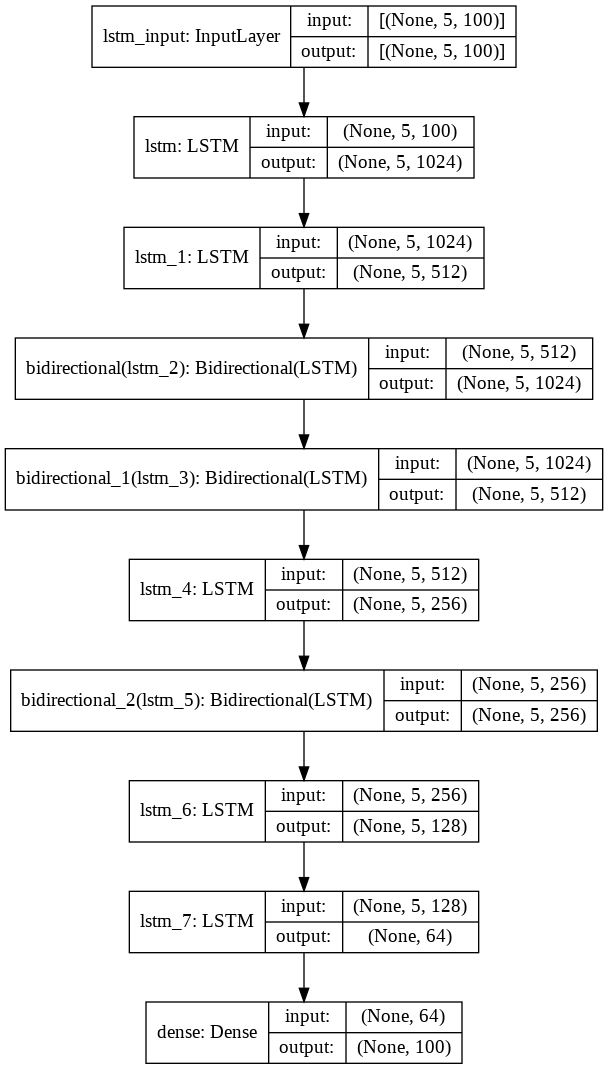

In [ ]:
model.save('drive/MyDrive/LARGE_PANDA/model_output/CASE_D_'+timestr+'.h')
plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/CASE_D_'+timestr+'.png', show_shapes=True)
Image(filename='drive/MyDrive/LARGE_PANDA/model_output/CASE_D_'+timestr+'.png')

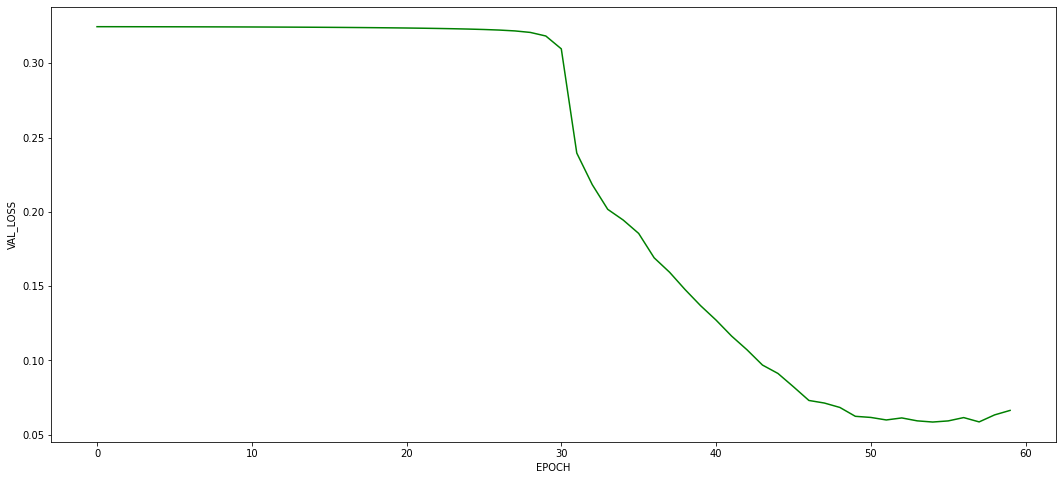

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['val_loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("VAL_LOSS")
plt.show()

In [ ]:
model = load_model('drive/MyDrive/LARGE_PANDA/model_output/CASE_20210218-1749.h')

[helpful link](https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)

In [ ]:
# make predictions
# trainPredict = model.predict(testX)
trainPredict = model.predict(t2data[50:].reshape(1,t2data[50:].shape[0],t2data[50:].shape[1]))

# testPredict = model.predict(testY)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform(trainY)
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform(testY)
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(testX, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict))
# print('Test Score: %.2f RMSE' % (testScore))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
batch =(t2data[40:50].reshape(1,t2data[40:50].shape[0],t2data[40:50].shape[1]))
cc=batch.shape[1]
pred_list = []
# batch=batch.T
for i in range(cc):
  # print(batch[0,1:,:])
  pred_list.append(model.predict(batch))#[0])  ## comment T then uncomment
  batch = np.append(batch[0,1:,:],pred_list[i],axis=0)
  # print([batch.shape,pred_list[i].T.shape])
  # batch=batch.T
  # print(pred_list[i])
  # print(pd.DataFrame(batch))
  batch = np.expand_dims(batch, 0)
  # print([i,batch.shape])
# print(pd.DataFrame(np.squeeze(pred_list)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
pred_list=pd.DataFrame(np.reshape(pred_list,[cc,t2data.shape[1]]))
scaler = MinMaxScaler(feature_range=(0, 1))
pred_list = scaler.fit_transform(pred_list)
# pred_list=scaler.transform((pred_list))
# pred_list=scaler.transform((pred_list))

# scaler = MinMaxScaler()
# scaler.fit(trainA)
# pred_list=scaler.transform((pred_list))
# pred_list = []
# batch = train[-n_input:].reshape((1, n_input, t2data.shape[1]))
# pred_list.append(model.predict(batch.T))
pred_list=(np.squeeze(pred_list))
pred_list=pd.DataFrame(pred_list)
print(pred_list)

# pred=pd.DataFrame(t2data[::-1])[6:]
pred=pd.DataFrame(t2data[:40])
pred=pred.append(pred_list)
pred=pred.reset_index()
del pred['index']

         0         1         2   ...        97        98        99
0  0.448271  0.204590  0.070639  ...  0.083368  0.194575  0.000000
1  0.487383  0.096674  0.029893  ...  0.477730  0.062245  0.102896
2  0.501516  0.000000  0.000000  ...  0.910312  0.000000  0.168027
3  0.494260  0.053566  0.032759  ...  1.000000  0.101695  0.244205
4  0.566991  0.166148  0.133975  ...  0.935323  0.276267  0.328850
5  0.656823  0.354890  0.213391  ...  0.637437  0.410575  0.218085
6  0.955433  0.486784  0.393304  ...  0.713149  0.492280  0.301237
7  1.000000  0.300880  0.552284  ...  0.428447  1.000000  1.000000
8  0.000000  1.000000  0.445448  ...  0.000000  0.421552  0.200719
9  0.756857  0.678626  1.000000  ...  0.406086  0.856033  0.389552

[10 rows x 100 columns]


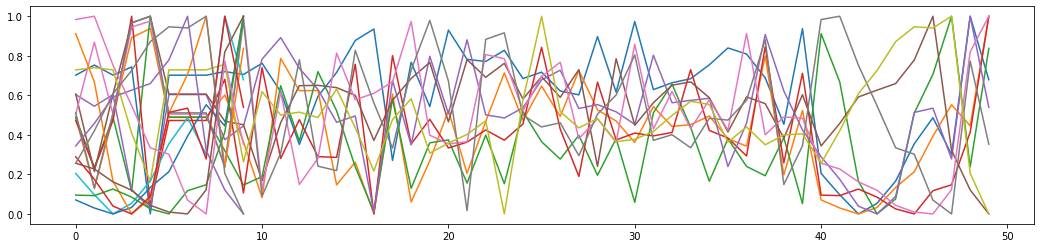

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(pred.iloc[:,1:cc])#.iloc[0:42,0:9])
w=plt.plot(pred_list.iloc[:,1:cc])

In [ ]:
trainScore = math.sqrt(mean_squared_error(t2data[40:50], pred_list))
print('Train Score: %.2f RMSE' % (trainScore))


Train Score: 0.42 RMSE


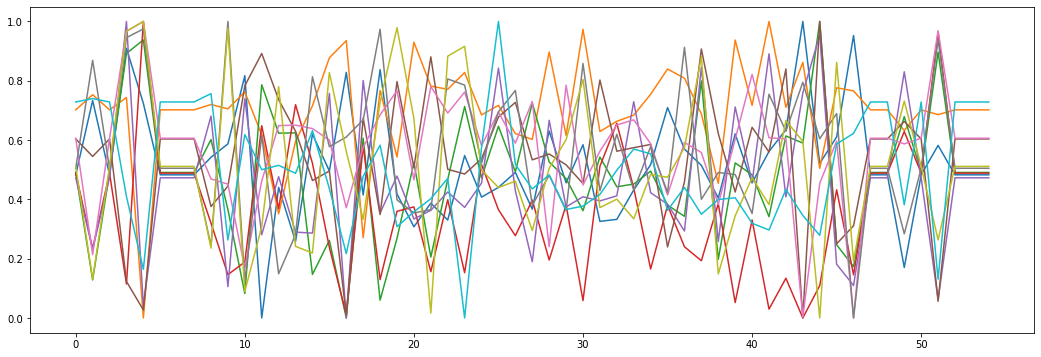

In [ ]:
plt.figure(figsize=(18, 6))
w=plt.plot(t2data[:,:10])#.iloc[0:42,0:9])

#ANOTHER MODEL

[FROM HERE](https://github.com/zhry10/DeepLSTM)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM, Activation#, CuDNNLSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import time
from random import shuffle
from sklearn.externals import joblib  # save scaler

# Setup GPU for training (use tensorflow v1.9 for CuDNNLSTM)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;


# Process full sequence to stacked sequence
def Generate_data(X_data0, y_data0, window_size=50):
    X_new_temp = []
    y_new_temp = []
    for ii in range(len(X_data0)):
        X_temp = X_data0[ii]
        y_temp = y_data0[ii]
        X_new = []
        y_new = []
        for jj in range(int(np.floor(len(X_temp) / window_size))):
            X_new.append(X_temp[jj * window_size:(jj + 1) * window_size])
            y_new.append(y_temp[(jj + 1) * window_size - 1, :])
            # y_new.append(y_temp[(jj + 1) * window_size - 1])

        X_new_temp.append(np.array(X_new))
        y_new_temp.append(np.array(y_new))

    X_data_new0 = np.array(X_new_temp)
    y_data_new0 = np.array(y_new_temp)

    return X_data_new0, y_data_new0


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:


# Load data
dataDir = 'deepLSTM_LTRC/'#C:/Users/sunsh/OneDrive/Desktop/CAS Paper/'  # Replace the directory


train_indices = mat['trainInd'] - 1
test_indices = mat['valInd'] - 1
pred_indices = mat['testInd'] - 1
X_data = mat['input_tf'][np.concatenate([train_indices[0], test_indices[0]])]
y_data = mat['target_tf'][np.concatenate([train_indices[0], test_indices[0]])]
# y_data = np.reshape(y_data, [y_data.shape[0], y_data.shape[1], 1])

# Scale data
X_data_flatten = np.reshape(X_data, [X_data.shape[0]*X_data.shape[1], 1])
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_X.fit(X_data_flatten)
X_data_flatten_map = scaler_X.transform(X_data_flatten)
X_data_map = np.reshape(X_data_flatten_map, [X_data.shape[0], X_data.shape[1], 1])

y_data_flatten = np.reshape(y_data, [y_data.shape[0]*y_data.shape[1], y_data.shape[2]])
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_y.fit(y_data_flatten)
y_data_flatten_map = scaler_y.transform(y_data_flatten)
y_data_map = np.reshape(y_data_flatten_map, [y_data.shape[0], y_data.shape[1], y_data.shape[2]])

# Unknown data
X_pred = mat['input_tf'][pred_indices[0]]
y_pred_ref = mat['target_tf'][pred_indices[0]]
# X_pred = np.reshape(X_pred, [X_pred.shape[0], X_pred.shape[1], 1])
# y_pred_ref = np.reshape(y_pred_ref, [y_pred_ref.shape[0], y_pred_ref.shape[1], 1])

# Scale data
X_pred_flatten = np.reshape(X_pred, [X_pred.shape[0]*X_pred.shape[1], 1])
X_pred_flatten_map = scaler_X.transform(X_pred_flatten)
X_pred_map = np.reshape(X_pred_flatten_map, [X_pred.shape[0], X_pred.shape[1], 1])

y_pred_ref_flatten = np.reshape(y_pred_ref, [y_pred_ref.shape[0]*y_pred_ref.shape[1], y_pred_ref.shape[2]])
y_pred_ref_flatten_map = scaler_y.transform(y_pred_ref_flatten)
y_pred_ref_map = np.reshape(y_pred_ref_flatten_map, [y_pred_ref.shape[0], y_pred_ref.shape[1], y_pred_ref.shape[2]])


In [ ]:

# Generate stacked data
windowsize = 10
X_data_new, y_data_new = Generate_data(X_data_map, y_data_map, windowsize)

X_data_new = np.reshape(X_data_new, [X_data_new.shape[0], X_data_new.shape[1], X_data_new.shape[2]])
# y_data = np.reshape(y_data, [y_data.shape[0], y_data.shape[1], 1])

X_train = X_data_new[0:len(train_indices[0])]
y_train = y_data_new[0:len(train_indices[0])]
X_test = X_data_new[len(train_indices[0]):]
y_test = y_data_new[len(train_indices[0]):]

X_pred, y_pred_ref = Generate_data(X_pred_map, y_pred_ref_map, windowsize)
X_pred = np.reshape(X_pred, [X_pred.shape[0], X_pred.shape[1], X_pred.shape[2]])

# n_epoch = 200
data_dim = X_train.shape[2]  # number of input features
timesteps = X_train.shape[1]
num_classes = y_train.shape[2]  # number of output features
batch_size = 10


In [ ]:

# rms = RMSprop(lr=0.001, decay=0.0001)
adam = Adam(lr=0.001, decay=0.0001)
model = Sequential()
model.add(LSTM(100, return_sequences=True, stateful=False, input_shape=(None, data_dim)))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, stateful=False))
model.add(Activation('relu'))
# model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.summary()

model.compile(loss='mean_squared_error',  # categorical_crossentropy, mean_squared_error, mean_absolute_error
              optimizer=adam,  # RMSprop(), Adagrad, Nadam, Adagrad, Adadelta, Adam, Adamax,
              metrics=['mse'])
best_loss = 100
train_loss = []
test_loss = []
history = []

with tf.device('/device:GPU:0'):

    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4
    # session = tf.Session(config=config)
    # tf.Session(config=tf.ConfigProto(log_device_placement=True))

    start = time.time()

    epochs = 50000
    for e in range(epochs):
        print('epoch = ', e + 1)

        # Shuffle data to maximize the usage of measurements
        Ind = list(range(len(X_data_new)))
        shuffle(Ind)
        ratio_split = 0.7
        Ind_train = Ind[0:round(ratio_split*len(X_data_new))]
        Ind_test = Ind[round(ratio_split*len(X_data_new)):]

        X_train = X_data_new[Ind_train]
        y_train = y_data_new[Ind_train]
        X_test = X_data_new[Ind_test]
        y_test = y_data_new[Ind_test]

        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  # validation_split=0.3,
                  validation_data=(X_test, y_test),
                  shuffle=True,
                  epochs=1)
        score0 = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
        score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
        train_loss.append(score0[0])
        test_loss.append(score[0])

        # Save the best trained model with minimum testing loss
        if test_loss[e] < best_loss:
            best_loss = test_loss[e]
            model.save(dataDir+'results/MRF-DBF/my_best_model.h5')

    end = time.time()
    running_time = (end - start)/3600
    print('Running Time: ', running_time, ' hour')

# Plot training and testing loss
plt.figure()
plt.plot(np.array(train_loss), 'b-')
plt.plot(np.array(test_loss), 'm-')

# plt.figure()
# plt.plot(np.log(np.array(train_loss)), 'b-')
# plt.plot(np.log(np.array(test_loss)), 'm-')
